# Tests

In [1]:
Threads.nthreads()

4

In [2]:
using LinearAlgebra
using Turing
using LimberJack
using PythonCall
using NPZ
using BenchmarkTools;

In [3]:
np = pyimport("numpy");

In [4]:
meta = np.load("../data/DECALS/DECALS_meta.npz")
files = npzread("../data/DECALS/DECALS_files.npz")

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [5]:
path = "/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_K1000_all_mag_correctMag/"
pars = np.loadtxt(string(path, "cl_cross_corr_v3_DES_K1000_all_mag_correctMag.bestfit"))
pars = pyconvert(Vector{Float64}, pars);

In [15]:
fake_cov = cov_tot + 9*Diagonal(cov_tot)
fake_inv_cov = pinv(fake_cov)

30×30 Matrix{Float64}:
      2.97619e10       5.39187e8   …    704.112         932.367
      5.39187e8        2.07793e11      1665.26         2255.3
      3.5853e7         1.95533e9       2819.58         3805.87
     -9.68801e7        1.4253e7       48838.5         63187.0
      8.64539e6       -5.28468e8      91003.6             1.20432e5
      8.97335e5        4.04689e7   …      1.71208e5       2.26598e5
      1.61605e6        3.75962e6          2.35828e5       3.04661e5
      1.92826e6        5.25671e6          3.02799e5       3.71833e5
      2.41771e6        5.82636e6          4.35285e5       4.94442e5
      2.98488e6        6.79882e6          6.61276e5       6.47471e5
      1.97991e5       -1.18543e5   …      1.43966e7       1.9052e7
 -88537.0              9.94701e5          2.27997e7       3.08619e7
  -3296.23            -3.15516e5          3.42186e7       4.61229e7
      ⋮                            ⋱                  
 -10360.6         -10485.3                3.77236e9       2.

In [16]:
function get_theory(Ωm, s8;
                 data_vector=data_vector,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31],
                     #"DECALS__0_0_dz" => pars[32],
                     #"DECALS__1_0_dz" => pars[33],
                     #"DECALS__2_0_dz" => pars[34],
                     #"DECALS__3_0_dz" => pars[35]
                     )
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    return theory

end

get_theory (generic function with 1 method)

In [17]:
fake_data = get_theory(0.3, 0.7);

In [18]:
#ls_tot = []
#for l in 1:length([item for item in keys(files) if occursin("ls", item)])
#    t1, t2 = pairs[l][1], pairs[l][2]
#    append!(ls_tot, files[string("ls_", t1, "_", t2)])
#end
#fake_cov = Diagonal(@.((2*data_vector^2)/((2*ls_tot+1)*0.23)))
#fake_inv_cov = inv(fake_cov)

## 2D Lkl

In [19]:
function get_Xi2(Ωm, s8;
                 data_vector=data_vector,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31])
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    diff = @.(theory-data_vector)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [20]:
get_Xi2(0.3, 0.7)

255.21373371892554

In [21]:
Ωms = LinRange(0.1, 0.6, 20)
s8s = LinRange(0.65, 0.9, 20)

20-element LinRange{Float64, Int64}:
 0.65,0.663158,0.676316,0.689474,0.702632,…,0.860526,0.873684,0.886842,0.9

In [22]:
Xi2s_emul = zeros(length(Ωms), length(s8s))
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_emul[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="emulator")
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

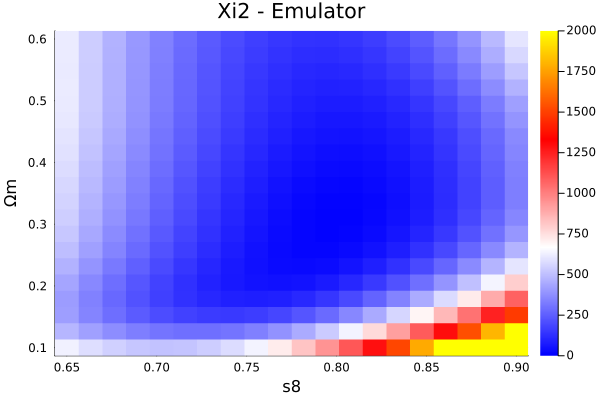

In [23]:
using Plots
gr()
heatmap(s8s, Ωms, Xi2s_emul,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clim=(0, 2000),
    title="Xi2 - Emulator")